In [1]:
#https://ianlondon.github.io/blog/how-to-sift-opencv/

In [2]:
%matplotlib inline
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def file_names(folder):
    names = []
    for filename in os.listdir(folder):
        names.append(filename[4:len(filename)-4])
    return names

In [5]:
train_images = load_images_from_folder("DatasetWithoutRotations/Training/png")

In [6]:
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

In [7]:
def gen_sift_features(gray_img):
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [8]:
trainImgKp, trainimgDesc = gen_sift_features(to_gray(train_images[0]))
#show_sift_features(to_gray(train_images[0]), train_images[0], trainImgKp);

In [9]:
test_images = load_images_from_folder("DatasetWithoutRotations/TestWithoutRotations/images")
#show_rgb_img(test_images[0])

In [10]:
testImgKp, testDesc = gen_sift_features(to_gray(test_images[0]))
#show_sift_features(to_gray(test_images[0]), test_images[0], testImgKp);

In [11]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(trainimgDesc, testDesc)

matches = sorted(matches, key = lambda x:x.distance)
N_MATCHES = 30

match_img = cv2.drawMatches(
    train_images[0], trainImgKp,
    test_images[0], testImgKp,
    matches[:N_MATCHES], None, flags=0)

#plt.figure(figsize=(12,6))
#plt.imshow(match_img);

In [12]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(trainimgDesc, testDesc,k=2)

good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        
match_img = cv2.drawMatchesKnn(
    train_images[0], trainImgKp,
    test_images[0], testImgKp,
    good, None, flags=2)

#plt.figure(figsize=(12,6))
#plt.imshow(match_img);

In [13]:
#for an image in train set, compare all test images
def lookAtMatches(trainImg, testImages):
    
    trainImgKp, trainimgDesc = gen_sift_features(to_gray(trainImg))
    
    for i in range(len(testImages)):
        
        testImgKp, testDesc = gen_sift_features(to_gray(testImages[i]))
        matches = bf.knnMatch(trainimgDesc, testDesc,k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.75 * n.distance:
                good.append([m])

        match_img = cv2.drawMatchesKnn(
            trainImg, trainImgKp,
            testImages[i], testImgKp,
            good, None, flags=2)
        
        if len(good)>=30:
            plt.figure(figsize=(12,6))
            plt.imshow(match_img);
            print(len(good)," ", i)
        

In [14]:
#for i in range(len(train_images)):
    #lookAtMatches(train_images[i],test_images)

In [15]:
def findHomography(img1, img2, name = None, minMatch = 10, ratio = 0.7,ransacThresh = 8.0):


    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)


    if len(good) > minMatch:
        
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacThresh)
        if M is None:
            return
        
        matchesMask = mask.ravel().tolist()
        h,w, mode = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, M)
        img2 = cv2.polylines(img2, [np.int32(dst)], True, (255, 0, 0), 3,cv2.LINE_AA)
        if name is not None:
            img2 = cv2.putText(img2, name, (int(dst[0][0][0]),int(dst[0][0][1]-10)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0), 1)


    else: 
        #print("no matches?")
        matchesMask = None
        return
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    return img2

In [16]:
iconNames = file_names("DatasetWithoutRotations/Training/png")

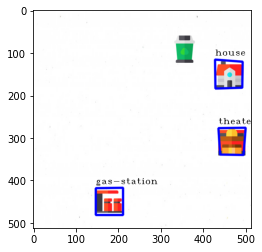

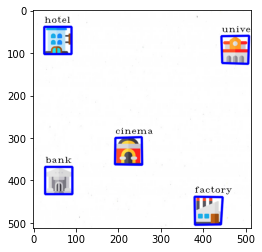

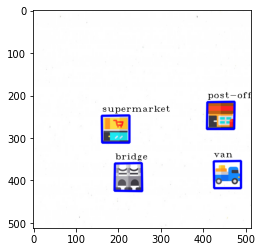

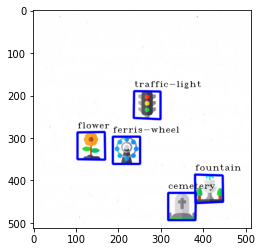

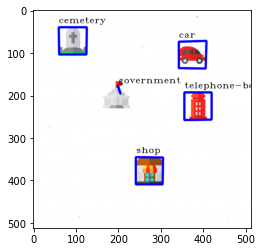

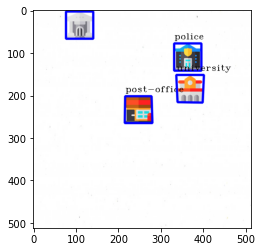

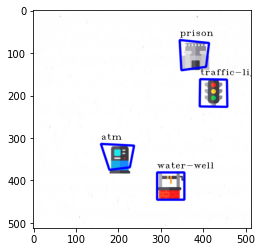

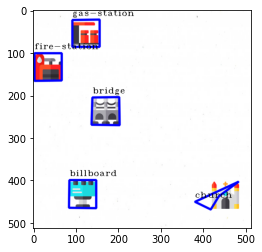

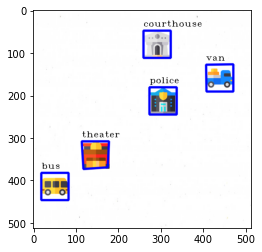

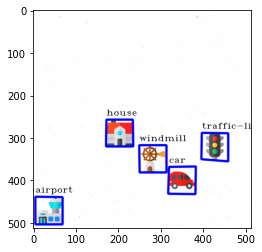

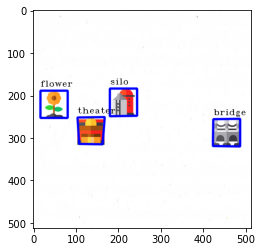

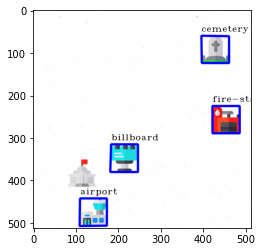

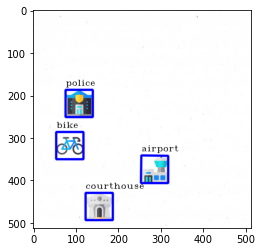

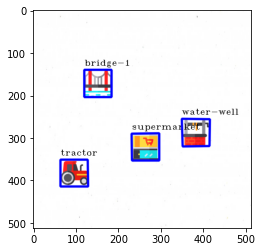

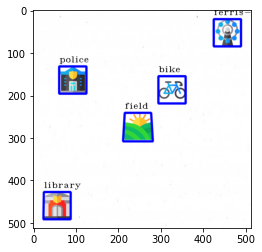

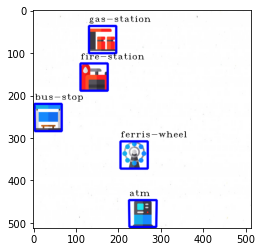

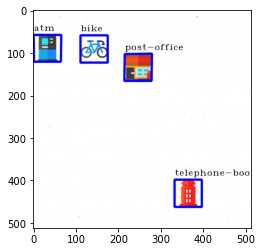

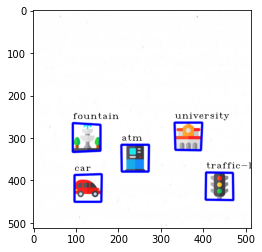

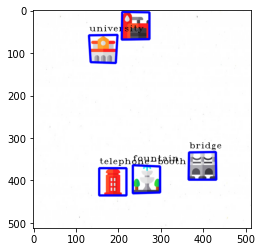

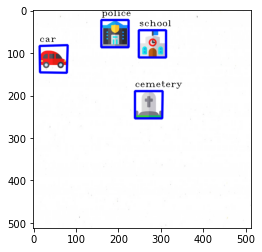

In [17]:
images = [""]*(len(test_images))
for i in range(len(test_images)):
    for j in range(len(train_images)):
        labelledIm = findHomography(train_images[j], test_images[i],iconNames[j], 4, 0.55, 5.25)
        
        if labelledIm is not None:
            images[i]=labelledIm
for image in images:
    plt.imshow(image),plt.show()    

In [18]:
#7, 0.60, 7.5
#3, 0.45, 4.0
#4, 0.45, 5.0
#4, 0.55, 5.0

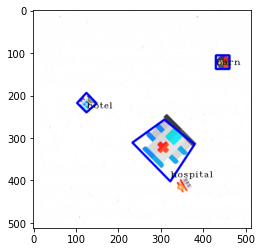

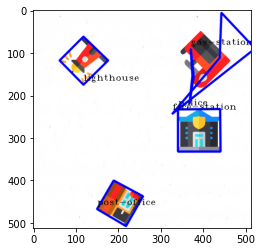

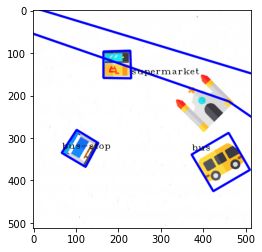

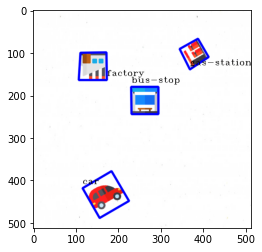

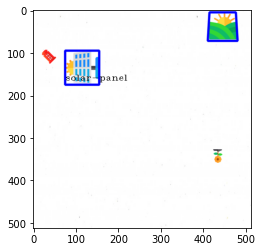

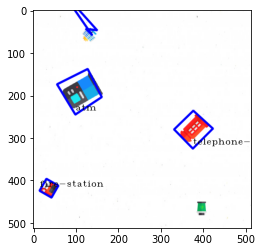

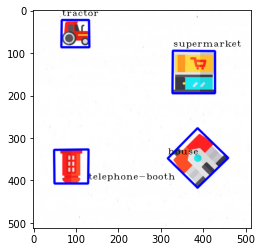

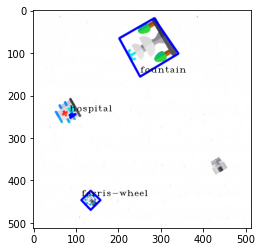

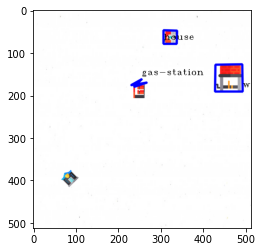

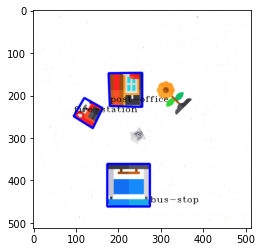

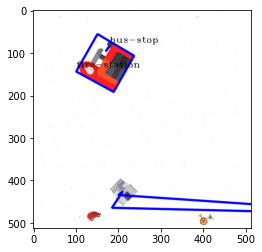

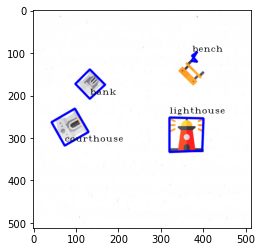

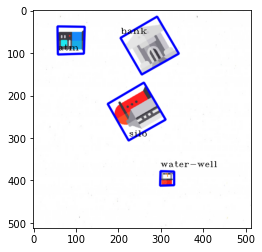

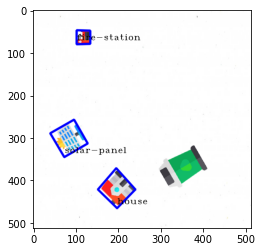

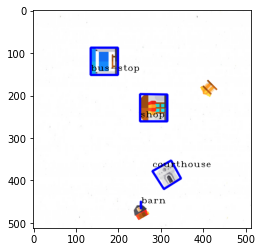

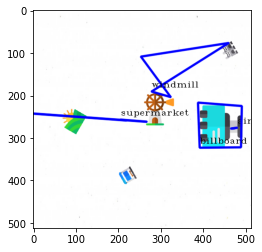

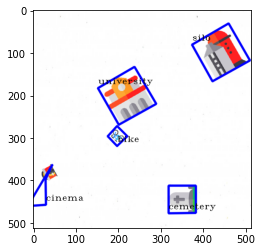

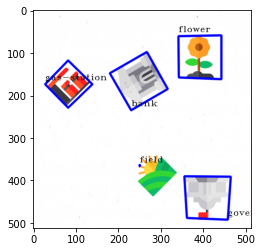

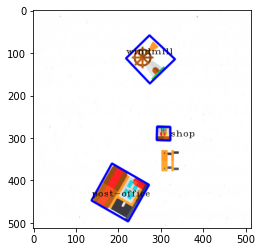

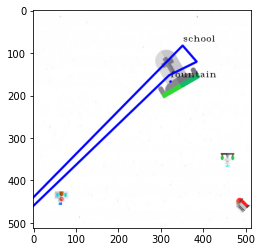

In [19]:
rotatedImages = load_images_from_folder("test_data_with_rotations/images")
images = [""]*(len(rotatedImages))
for i in range(len(rotatedImages)):
    for j in range(len(train_images)):
        labelledIm = findHomography(train_images[j], rotatedImages[i],iconNames[j], 4, 0.55, 3.25)        
        if labelledIm is not None:
            images[i]=labelledIm
for image in images:
    plt.imshow(image),plt.show()

In [20]:
img=cv2.drawKeypoints(to_gray(train_images[0]), trainImgKp, train_images[0] ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [21]:
trainimgDesc[0]

array([  1.,   3.,   0.,   0.,   0.,   0.,   0.,   0., 172.,  77.,   0.,
         0.,   0.,   0.,   0.,   0., 177.,  93.,   0.,   0.,   0.,   0.,
         0.,   0.,  13.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., 177.,  22.,   0.,   0.,
         0.,   0.,   0.,   1., 177.,  59.,   0.,   0.,   0.,   0.,   0.,
         5.,  33.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.,   0., 177.,   2.,   0.,   0.,   0.,
         0.,   0.,  17., 177.,   8.,   0.,   0.,   0.,   0.,   0.,  43.,
        33.,   1.,   0.,   0.,   0.,   0.,   0.,   4.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 146.,  17.,   1.,   0.,   0.,   0.,
         0.,  13., 177.,  20.,   0.,   0.,   0.,   0.,   0.,  13.,   6.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [22]:
print (len(testImgKp)), 'keypoints in the list'
print (testImgKp[0])

161
<KeyPoint 00000259FC94BD80>


In [23]:
def explain_keypoint(kp):
    print ('angle\n', kp.angle)
    print ('\nclass_id\n', kp.class_id)
    print ('\noctave (image scale where feature is strongest)\n', kp.octave)
    print ('\npt (x,y)\n', kp.pt)
    print ('\nresponse\n', kp.response)
    print ('\nsize\n', kp.size)

print ('this is an example of a single SIFT keypoint:\n* * *')
explain_keypoint(testImgKp[0])

this is an example of a single SIFT keypoint:
* * *
angle
 99.46682739257812

class_id
 -1

octave (image scale where feature is strongest)
 15270399

pt (x,y)
 (149.1792449951172, 474.3583068847656)

response
 0.059848394244909286

size
 2.218261241912842


In [24]:
bigKp = []
for i in range(len(trainImgKp)):
    if(trainImgKp[i].size > 30):
        bigKp.append(trainImgKp[i])

In [25]:
def bigKeypoints (poop):
    bigKp = []
    for i in range(len(poop)):
        if(poop[i].size > 30):
            bigKp.append(poop[i])
    return bigKp


In [26]:
bigTrainKp = bigKeypoints(testImgKp)
bigTestKp = bigKeypoints(trainImgKp)
